# Initial Imports, Mount Drive


In [1]:
%%time
!pip install -q condacolab
import condacolab
condacolab.install()
!conda --version

!conda install ffmpeg=4.3 -c conda-forge
#!apt install ffmpeg
#!apt install ffmpeg=4.3 -c conda-forge

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:28
🔁 Restarting kernel...
conda 4.14.0
Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | failed with initial frozen solve. Retrying with flexible solve.
Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done


==> WARNING: A newer version of conda exists. <==
  current versi

In [1]:
# Initial imports
import numpy as np
import os
import pandas as pd
# needed to install torch like so:
#         pip3 install torch torchvision torchaudio
import tensorflow as tf # this needs to happen before any torch imports....
import torchaudio
import os

import librosa
import matplotlib.pyplot as plt
#import requests
from IPython.display import Audio, display
from google.colab import drive

from collections import Counter
from torch.utils.data import Dataset
from tqdm import tqdm
import random
import keras 

# Mount Drive
drive.mount('/content/gdrive')

archive_path = "./gdrive/MyDrive/Accent_Recognition/archive"
recordings_path = "./gdrive/MyDrive/Accent_Recognition/archive/recordings/recordings"  


# define global variagbles
samples_per_batch = 32
spectrogram_max_length = 7336
number_of_mels = 128
random_seed_number = 108


# set the random seed
random.seed(random_seed_number)

Mounted at /content/gdrive


# Define Dataset Classes and Helper Functions

In [ ]:
############
# Define a dataset class
#
# this should have methods for:
# loading
# preprocessing
# filtering
# train / test / validation splitting
###########

random.seed(random_seed_number)

def plot_spectrogram(spec, title=None, ylabel="freq_bin", aspect="auto", xmax=None):
    fig, axs = plt.subplots(1, 1, figsize=(10, 8))
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(spec), origin="lower", aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

def play_audio(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    if num_channels == 1:
        display(Audio(waveform[0], rate=sample_rate))
    elif num_channels == 2:
        display(Audio((waveform[0], waveform[1]), rate=sample_rate))
    else:
        raise ValueError("Waveform with more than 2 channels are not supported.")

mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=44100,
    n_fft=1024,
    win_length=None,
    hop_length=512,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm="slaney",
    onesided=True,
    n_mels=128,
    mel_scale="htk",
)

class AccentDataset(Dataset):
    def __init__(self, audio_files_folder, metadata_file, make_spectra=False, language_samples_threshold = 30):
        self.audio_files_folder = audio_files_folder
        self.metadata_file = metadata_file
        self.make_spectra = make_spectra
        self.metadata = self.load_metadata()
        self.language_samples_threshold = language_samples_threshold
        self.metadata = self.filter_metadata()
        self.audio = self.load_audio()
        if not make_spectra:
            self.load_spectrograms()
        self.training_fraction = 0.67
        self.downsample_training = True
        self.downsampled_number = 5
        self.train_indices, self.test_indices = self.create_train_test_split()
        
    def load_metadata(self):
        metadata = pd.read_csv(self.metadata_file)
        return metadata
    
    def filter_metadata(self):
        self.metadata = self.metadata[self.metadata['file_missing?'] != True]
        samples_per_language = Counter(self.metadata['native_language'])    
        filtered_languages = [language for language in samples_per_language.keys() if \
                              samples_per_language[language] >= self.language_samples_threshold]
        filtered_speakers = self.metadata[self.metadata['native_language'].isin(filtered_languages)]
        return filtered_speakers
    
    def load_audio(self):
        audio = {}
        for file_index in tqdm(self.metadata.index):
            file_name = self.metadata.loc[file_index]['filename']
            audio_file = AudioFile(file_name, self.audio_files_folder, self.metadata.loc[file_index])
            if self.make_spectra:
                audio_file.make_mel_spectrogram()
            audio[file_name] = audio_file
        return audio

    def write_spectrograms(self):
        print("Writing Spectrograms to Disk")
        for file_index in tqdm(self.metadata.index):
            file_name = self.metadata.loc[file_index]['filename']
            spectrogram_file_full_path = os.path.join(os.path.dirname(self.audio_files_folder), 'Spectra', file_name)
            np.save(spectrogram_file_full_path, self.audio[file_name].spectrogram)

    def load_spectrograms(self):
        for file_index in tqdm(self.metadata.index):
            file_name = self.metadata.loc[file_index]['filename']
            spectrogram_file_full_path = os.path.join(os.path.dirname(self.audio_files_folder), 'Spectra', file_name + '.npy')
            self.audio[file_name].spectrogram = np.load(spectrogram_file_full_path)
    
    def create_train_test_split(self):
        unique_languages = list(set(self.metadata['native_language']))
        train_indices =[]
        test_indices = []
        for language in unique_languages:
            this_language = self.metadata[self.metadata['native_language'] == language]
            this_language_male = this_language[this_language['sex']=='male']
            this_language_female = this_language[this_language['sex']=='female']
            traininds_male = random.sample(list(this_language_male.index), 
                                           int(self.training_fraction * len(this_language_male.index)))
            traininds_female = random.sample(list(this_language_female.index), 
                                           int(self.training_fraction * len(this_language_female.index)))
            traininds = traininds_male + traininds_female
            testinds = list(set(this_language.index) - set(traininds))
            if self.downsample_training:                
                traininds = traininds_male[:self.downsampled_number] + traininds_female[:self.downsampled_number]
            train_indices += traininds
            test_indices += testinds
        return sorted(train_indices), sorted(test_indices)
    
    
class AccentDatasetBatch(Dataset):
    def __init__(self, audio_files_folder, metadata):
        self.audio_files_folder = audio_files_folder
        self.metadata = metadata
        self.audio = self.load_audio()
        self.load_spectrograms()

    
    def load_audio(self):
        audio = {}
        for file_index in tqdm(self.metadata.index):
            file_name = self.metadata.loc[file_index]['filename']
            audio_file = AudioFile(file_name, self.audio_files_folder, self.metadata.loc[file_index])
            # if self.make_spectra:
            #     audio_file.make_mel_spectrogram()
            audio[file_name] = audio_file
        return audio

    def load_spectrograms(self):
        for file_index in tqdm(self.metadata.index):
            file_name = self.metadata.loc[file_index]['filename']
            spectrogram_file_full_path = os.path.join(os.path.dirname(self.audio_files_folder), 'Spectra', file_name + '.npy')
            #print(f"loading {file_name}")
            self.audio[file_name].spectrogram = np.load(spectrogram_file_full_path)


class AudioFile(object):
    def __init__(self, file_name, file_path, metadata_row):
        self.file_name = file_name
        self.file_path = file_path
        self.waveform = None
        self.spectrogram = None
        self.language = metadata_row['native_language']
        self.age = metadata_row['age']
        self.sex = metadata_row['sex']
        self.metadata_row = metadata_row
    
    def __repr__(self):
        return self.file_name
        
    def load_audio_file(self):
        full_path = os.path.join(self.file_path, self.file_name + ".mp3")
        self.waveform, self.sample_rate = torchaudio.load(full_path, normalize=True)
    
    def make_mel_spectrogram(self, 
                             n_fft = 1024, 
                             win_length = None, 
                             hop_length = 512, 
                             n_mels = 128):
        mel_spectrogram = torchaudio.transforms.MelSpectrogram(
            sample_rate=44100,
            n_fft=n_fft,
            win_length=win_length,
            hop_length=hop_length,
            center=True,
            pad_mode="reflect",
            power=2.0,
            norm="slaney",
            onesided=True,
            n_mels=n_mels,
            mel_scale="htk",
        )
        if self.waveform is None:
            self.load_audio_file()
        self.spectrogram = mel_spectrogram(self.waveform)
    
    def plot_spectrogram(self):
        if self.spectrogram is None:
            self.spectrogram = mel_spectrogram(self.waveform)
        plot_spectrogram(self.spectrogram[0,:,:200], title=self.file_name)
        plot_spectrogram(self.spectrogram[0], title=self.file_name)
    
    def play_recording(self):
        play_audio(self.waveform, self.sample_rate)
    
print("finished defining")

finished defining


/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:540: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "


# Write Spectra to Disk, Display Examples, One Time Only

In [ ]:
write_spectra_to_disk = False
use_full_dataset = True
display_examples = False
calculate_max_spectrum_length = True

if write_spectra_to_disk:
    archive_path = "./gdrive/MyDrive/Accent_Recognition/archive"
    recordings_path = "./gdrive/MyDrive/Accent_Recognition/archive/recordings/recordings"  
    if use_full_dataset:
      speakers_file_name = "speakers_all.csv"
    else:
      speakers_file_name = "speakers_half.csv"
    full_dataset = AccentDataset(audio_files_folder=recordings_path, 
                                 metadata_file=os.path.join(archive_path,speakers_file_name),
                                 make_spectra=True, 
                                 language_samples_threshold = )
    full_dataset.write_spectrograms()
    print("DONE")

if display_examples:
    af1 = af2 = None
    af1 = full_dataset.audio['dutch10']
    af1.plot_spectrogram()
    af1.play_recording()
    af2 = full_dataset.audio['korean44']
    af2.plot_spectrogram()
    af2.play_recording()  

if calculate_max_spectrum_length:
    spectra_folder ="./gdrive/MyDrive/Accent_Recognition/archive/recordings/Spectra"
    spectra_file_names = os.listdir(spectra_folder)
    print(spectra_file_names)
    spectrogram_lengths = {}
    just_lengths = []
    for file_name in spectra_file_names:
        spectrogram_file_full_path = os.path.join(spectra_folder, file_name)
        spectrogram = np.load(spectrogram_file_full_path)
        this_length = spectrogram.shape[2]
        spectrogram_lengths[file_name] = this_length
        just_lengths.append(spectrogram_lengths[file_name])
        #print(this_length)
    max_spectral_length = max(just_lengths)
    print(f"max length: {max_spectral_length}" ) # 7336, now 9988

100%|██████████| 1768/1768 [11:46<00:00,  2.50it/s]


Writing Spectrograms to Disk


100%|██████████| 1768/1768 [00:22<00:00, 76.94it/s]


DONE
['english241.npy', 'english242.npy', 'english243.npy', 'english244.npy', 'english245.npy', 'english246.npy', 'english247.npy', 'english248.npy', 'english249.npy', 'english25.npy', 'english250.npy', 'english251.npy', 'english252.npy', 'english253.npy', 'english254.npy', 'english255.npy', 'english256.npy', 'english257.npy', 'english258.npy', 'english259.npy', 'english26.npy', 'english260.npy', 'english261.npy', 'english262.npy', 'english263.npy', 'english264.npy', 'english265.npy', 'english266.npy', 'english267.npy', 'english268.npy', 'english269.npy', 'english27.npy', 'english270.npy', 'english271.npy', 'english272.npy', 'english273.npy', 'english274.npy', 'english275.npy', 'english276.npy', 'english277.npy', 'english278.npy', 'english279.npy', 'english28.npy', 'english280.npy', 'english281.npy', 'english282.npy', 'english283.npy', 'english284.npy', 'english285.npy', 'english286.npy', 'english287.npy', 'english288.npy', 'english289.npy', 'english29.npy', 'english290.npy', 'english2

# TF CN-LSTM create TF Tensors for Training and Testing, revisit - may be needed for padding of inputs


In [ ]:
# pack the training and testing spectrograms into tensors with zero padding:
import tensorflow as tf
import numpy as np
def make_input_and_target(file_names, spectrogram_lengths): 
    number_of_files = len(file_names)
    input_tensor = np.zeros([number_of_files,
                               spectrogram_max_length,
                               number_of_mels])
    # input_tensor = torch.zeros(number_of_files,
    #                            spectrogram_max_length,
    #                            number_of_mels)
    # target_tensor = torch.zeros(number_of_files, 
    #                             number_of_training_languages)
    target_tensor = np.zeros([number_of_files, 
                                number_of_training_languages])
    for file_number in range(number_of_files):
        input_tensor[file_number, :spectrogram_lengths[file_number], :] = \
            full_dataset.audio[file_names[file_number]].spectrogram.T[:,:,0]
        file_language = full_dataset.audio[file_names[file_number]].language
        target_tensor[file_number, training_languages_dict[file_language]] = 1
    return input_tensor, target_tensor

 
def make_input_and_target_gender(file_names, spectrogram_lengths): 
    number_of_files = len(file_names)
    # input_tensor = torch.zeros(number_of_files,
    #                            spectrogram_max_length,
    #                            number_of_mels)
    # target_tensor = torch.zeros(number_of_files, 2)
    input_tensor = np.zeros([number_of_files,
                               spectrogram_max_length,
                               number_of_mels])
    target_tensor = np.zeros([number_of_files, 2])
    for file_number in range(number_of_files):
        input_tensor[file_number, :spectrogram_lengths[file_number], :] = \
            full_dataset.audio[file_names[file_number]].spectrogram.T[:,:,0]
        file_gender = full_dataset.audio[file_names[file_number]].sex
        target_tensor[file_number, training_gender_dict[file_gender]] = 1
    return input_tensor, target_tensor


use_gender = True
if use_gender:
    training_input, training_target = make_input_and_target_gender(file_names_training, spectrogram_lengths_training)
    testing_input, testing_target = make_input_and_target_gender(file_names_testing, spectrogram_lengths_testing)
else:
    training_input, training_target = make_input_and_target(file_names_training, spectrogram_lengths_training)
    testing_input, testing_target = make_input_and_target(file_names_testing, spectrogram_lengths_testing)
print("finished")

NameError: ignored

# Define Filtering and Splitting Functions

In [ ]:
def filter_metadata(metadata_unfiltered, language_samples_threshold = 30, max_samples_per_language = np.inf):
    metadata = metadata_unfiltered[metadata_unfiltered['file_missing?'] != True]
    samples_per_language = Counter(metadata['native_language'])    
    filtered_languages = [language for language in samples_per_language.keys() if samples_per_language[language] >= language_samples_threshold]
    filtered_speakers = metadata[metadata['native_language'].isin(filtered_languages)]
    if np.isfinite(max_samples_per_language):
      filtered_speakers = filtered_speakers.groupby('native_language').head(max_samples_per_language).reset_index(drop=True)
    filtered_speakers.reset_index(inplace=True)
    return filtered_speakers


def create_train_test_split(metadata,
                            training_fraction=.67,
                            downsampled_number = 5,
                            downsample_training=False):
    unique_languages = list(set(metadata['native_language']))
    train_indices =[]
    test_indices = []
    for language in unique_languages:
        this_language = metadata[metadata['native_language'] == language]
        this_language_male = this_language[this_language['sex']=='male']
        this_language_female = this_language[this_language['sex']=='female']
        traininds_male = random.sample(list(this_language_male.index), 
                                        int(training_fraction * len(this_language_male.index)))
        traininds_female = random.sample(list(this_language_female.index), 
                                        int(training_fraction * len(this_language_female.index)))
        traininds = traininds_male + traininds_female
        testinds = list(set(this_language.index) - set(traininds))
        if downsample_training:                
            traininds = traininds_male[:downsampled_number] + traininds_female[:downsampled_number]
        train_indices += traininds
        test_indices += testinds
    return sorted(train_indices), sorted(test_indices)

# Define the Metadata and Target Dictionaries

In [ ]:
##################
# Load the metadata
##################

metadata_unfiltered = pd.read_csv(os.path.join("./gdrive/MyDrive/Accent_Recognition/archive", 
                                         "speakers_half.csv"))
metadata_unfiltered.drop(metadata_unfiltered.iloc[:,9:12],axis=1,inplace=True)

##################
# Produce filtered training and testing metadata dataframes
##################

filtered_metadata = filter_metadata(metadata_unfiltered, language_samples_threshold = 10, max_samples_per_language=10)
train_indices, test_indices = create_train_test_split(filtered_metadata)
metadata_train = filtered_metadata.iloc[train_indices]
metadata_test = filtered_metadata.iloc[test_indices]


##################
# Define Language Target Dictionary
##################

training_languages = list(set(filtered_metadata['native_language']))
number_of_training_languages = len(training_languages)
training_languages_dict = dict(zip(training_languages, list(range(number_of_training_languages))))

##################
# Define Gender Target Dictionary
##################

training_genders = list(set(filtered_metadata['sex']))
number_of_training_genders = len(training_genders)
training_gender_dict = dict(zip(training_genders, list(range(number_of_training_genders))))


print("\n")
print(filtered_metadata['native_language'].value_counts())

print("\n")
print(f"Number of missing files: {sum(filtered_metadata['file_missing?'])}")

print("\n")
print(metadata_train['native_language'].value_counts())

print("\n")
print(metadata_test['native_language'].value_counts())


amharic      10
arabic       10
bengali      10
bulgarian    10
cantonese    10
dutch        10
english      10
farsi        10
french       10
Name: native_language, dtype: int64
0


amharic      6
arabic       6
bengali      6
bulgarian    6
cantonese    6
dutch        6
english      6
farsi        6
french       6
Name: native_language, dtype: int64
amharic      4
arabic       4
bengali      4
bulgarian    4
cantonese    4
dutch        4
english      4
farsi        4
french       4
Name: native_language, dtype: int64


# Cutom Generator Class


In [ ]:
# create data generator class
# following pattern from here: https://medium.com/analytics-vidhya/write-your-own-custom-data-generator-for-tensorflow-keras-1252b64e41c3

#import tensorflow as tf

class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self,
                target_dict,
                metadata,
                target = 'sex', 
                batch_size=samples_per_batch, 
                spectrogram_max_length=spectrogram_max_length,
                number_of_mels=number_of_mels,
                randomize=True):
        self.target_dict = target_dict 
        self.target = target
        self.metadata = metadata
        self.number_of_inputs = self.metadata.shape[0]
        self.file_names = list(self.metadata['filename'])
        self.spectrogram_max_length = spectrogram_max_length
        self.number_of_mels = number_of_mels
        self.batch_size = batch_size      
        self.randomize = randomize  
        self.recordings_path = "./gdrive/MyDrive/Accent_Recognition/archive/recordings/recordings"  

    def on_epoch_end(self):
        if self.randomize:
          L = list(range(self.number_of_inputs))
          random.shuffle(L)
          self.metadata = self.metadata.iloc[L].reset_index(drop=True)
          #self.file_names = self.file_names[L]
          #self.spectrogram_lengths = self.spectrogram_lengths[L]
   
    def __getitem__(self, index):
        # The role of __getitem__ method is to generate one batch of data.
        number_of_inputs = self.metadata.shape[0]  
        L=list(range(number_of_inputs))
        metadata_batch = self.metadata.iloc[index * self.batch_size:(index + 1) * self.batch_size]
        data_batch = AccentDatasetBatch(self.recordings_path, metadata_batch)
        batch_file_names = list(data_batch.audio.keys())
        # print("***********")
        # print(self.metadata.shape)
        # print(index * self.batch_size)
        # print((index + 1) * self.batch_size)
        # print(batch_file_names)
        #number_of_mels = data_batch.audio[batch_file_names[0]].spectrogram.shape[1]
        number_of_mels = self.number_of_mels
        spectrogram_lengths = []
        for file_number in range(len(batch_file_names)):
          spectrogram_lengths.append(data_batch.audio[batch_file_names[file_number]].spectrogram.T[:,:,0].shape[0])
        spectrogram_max_length = self.spectrogram_max_length
        batch_inputs = np.zeros([self.batch_size, spectrogram_max_length, self.number_of_mels])
        batch_targets = np.zeros([self.batch_size, len(self.target_dict)])
        batch_ys = np.zeros([self.batch_size])
        for file_number in range(len(batch_file_names)):
          batch_inputs[file_number, :spectrogram_lengths[file_number], :] = \
            data_batch.audio[batch_file_names[file_number]].spectrogram.T[:,:,0]
          if self.target == 'sex':
            file_gender = data_batch.audio[batch_file_names[file_number]].sex
            batch_targets[file_number, self.target_dict[file_gender]] = 1 # this is one-hot encoded
            batch_ys = self.target_dict[file_gender] 
          elif self.target == 'language':
            file_language = data_batch.audio[batch_file_names[file_number]].language
            batch_targets[file_number, self.target_dict[file_language]] = 1 # this is one-hot encoded
            batch_ys = self.target_dict[file_language] 
          else:
            raise ValueError('target must be one of sex or language')
        # print("$$$$$$$$$")
        # print(batch_targets.shape)
        # print(batch_targets)     
        return batch_inputs, (batch_targets,)
        #return batch_inputs, batch_ys

    def __len__(self):
       #__len__ will return the number of batches the generator can produce and it will be floor(number_of_samples // batch_size)
        return self.number_of_inputs // self.batch_size


traingen = CustomDataGen(target_dict=training_gender_dict, 
                          metadata=metadata_train,
                          target = 'sex',
                          batch_size=32,
                          spectrogram_max_length=spectrogram_max_length,
                          number_of_mels=number_of_mels)


valgen = CustomDataGen(target_dict=training_gender_dict, 
                        metadata=metadata_test,
                        target = 'sex',
                        batch_size=32,
                        spectrogram_max_length=spectrogram_max_length,
                        number_of_mels=number_of_mels)


# Language Generators

In [ ]:
#############
# Language Generator Definition
#############
traingen_language = CustomDataGen(target_dict=training_languages_dict, 
                          metadata=metadata_train,
                          target = 'language',
                          batch_size=32,
                          spectrogram_max_length=spectrogram_max_length,
                          number_of_mels=number_of_mels)


valgen_language = CustomDataGen(target_dict=training_languages_dict, 
                        metadata=metadata_test,
                        target = 'language',
                        batch_size=32,
                        spectrogram_max_length=spectrogram_max_length,
                        number_of_mels=number_of_mels)

# how many training batches in the full dataset?
print(metadata_train.shape)
print(metadata_test.shape)

(54, 10)
(36, 10)


# Language Model Definition

In [ ]:
####################
# Language Model Definition
####################

from keras.layers.pooling import MaxPooling2D
from keras.layers.convolutional import Conv2D
import tensorflow as tf
from keras.models import Sequential
#from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Input, Bidirectional, LSTM, Dropout
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Softmax  
#from keras.layers.embeddings import Embedding
from keras.regularizers import l2
from keras.models import Model


model_language = Sequential()
model_language.add(Conv2D(6, 
                 (5, 5), 
                 activation='relu', 
                 input_shape=(spectrogram_max_length, 
                              number_of_mels, 
                              1)))
model_language.add(MaxPooling2D(2, 2))

model_language.add(Conv2D(16, 
                 (5, 5), 
                 activation='relu'))
model_language.add(MaxPooling2D(2, 2))

model_language.add(Flatten())

model_language.add(Dense(len(training_languages_dict)))
model_language.add(Softmax())

model_language.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy())

# Language Model Training

In [ ]:
################################################
# Model Training
# Language Model
################################################
import os
model = None

language_model_filepath = './gdrive/MyDrive/Accent_Recognition/KerasModels/'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    os.path.join(language_model_filepath,'checkpoint'), 
    monitor='val_loss', 
    verbose=0, 
    save_best_only=False, 
    save_weights_only=False, 
    mode='auto', 
    save_freq=16)

model = model_language
num_epochs = 50

print(num_epochs)
training_history = model.fit(traingen_language,
          validation_data=valgen_language,
          callbacks=[model_checkpoint_callback],
          epochs=num_epochs)


# # Save the weights
model.save(os.path.join(language_model_filepath,'LanguageModel'))

50


100%|██████████| 32/32 [00:00<00:00, 276.48it/s]


Epoch 1/50


100%|██████████| 32/32 [00:00<00:00, 273.16it/s]


1/1 [==============================] - ETA: 0s - loss: 2.2964

100%|██████████| 32/32 [00:00<00:00, 266.01it/s]


1/1 [==============================] - 2s 2s/step - loss: 2.2964 - val_loss: 24.1308
Epoch 2/50


100%|██████████| 32/32 [00:00<00:00, 269.31it/s]


1/1 [==============================] - ETA: 0s - loss: 20.6503

100%|██████████| 32/32 [00:00<00:00, 291.28it/s]


1/1 [==============================] - 1s 1s/step - loss: 20.6503 - val_loss: 25.8301
Epoch 3/50


100%|██████████| 32/32 [00:00<00:00, 240.41it/s]


1/1 [==============================] - ETA: 0s - loss: 12.5986

100%|██████████| 32/32 [00:00<00:00, 287.96it/s]


1/1 [==============================] - 1s 888ms/step - loss: 12.5986 - val_loss: 19.2557
Epoch 4/50


100%|██████████| 32/32 [00:00<00:00, 256.45it/s]


1/1 [==============================] - ETA: 0s - loss: 4.4797

100%|██████████| 32/32 [00:00<00:00, 280.57it/s]


1/1 [==============================] - 1s 883ms/step - loss: 4.4797 - val_loss: 10.7201
Epoch 5/50


100%|██████████| 32/32 [00:00<00:00, 281.41it/s]


1/1 [==============================] - ETA: 0s - loss: 0.2126

100%|██████████| 32/32 [00:00<00:00, 291.64it/s]


1/1 [==============================] - 1s 860ms/step - loss: 0.2126 - val_loss: 12.1165
Epoch 6/50


100%|██████████| 32/32 [00:00<00:00, 320.16it/s]


1/1 [==============================] - ETA: 0s - loss: 0.0322

100%|██████████| 32/32 [00:00<00:00, 284.12it/s]


1/1 [==============================] - 1s 1s/step - loss: 0.0322 - val_loss: 14.0573
Epoch 7/50


100%|██████████| 32/32 [00:00<00:00, 278.65it/s]


1/1 [==============================] - ETA: 0s - loss: 0.0632

100%|██████████| 32/32 [00:00<00:00, 272.58it/s]


1/1 [==============================] - 1s 1s/step - loss: 0.0632 - val_loss: 18.8562
Epoch 8/50


100%|██████████| 32/32 [00:00<00:00, 270.14it/s]


1/1 [==============================] - ETA: 0s - loss: 0.1069

100%|██████████| 32/32 [00:00<00:00, 283.56it/s]


1/1 [==============================] - 1s 863ms/step - loss: 0.1069 - val_loss: 18.9460
Epoch 9/50


100%|██████████| 32/32 [00:00<00:00, 286.93it/s]


1/1 [==============================] - ETA: 0s - loss: 0.2589

100%|██████████| 32/32 [00:00<00:00, 298.67it/s]


1/1 [==============================] - 1s 858ms/step - loss: 0.2589 - val_loss: 20.0268
Epoch 10/50


100%|██████████| 32/32 [00:00<00:00, 258.19it/s]


1/1 [==============================] - ETA: 0s - loss: 0.5531

100%|██████████| 32/32 [00:00<00:00, 278.84it/s]


1/1 [==============================] - 1s 879ms/step - loss: 0.5531 - val_loss: 21.1776
Epoch 11/50


100%|██████████| 32/32 [00:00<00:00, 270.12it/s]


1/1 [==============================] - ETA: 0s - loss: 0.3578

100%|██████████| 32/32 [00:00<00:00, 252.80it/s]


1/1 [==============================] - 1s 876ms/step - loss: 0.3578 - val_loss: 17.7078
Epoch 12/50


100%|██████████| 32/32 [00:00<00:00, 284.76it/s]


1/1 [==============================] - ETA: 0s - loss: 0.3411

100%|██████████| 32/32 [00:00<00:00, 277.04it/s]


1/1 [==============================] - 1s 882ms/step - loss: 0.3411 - val_loss: 18.7400
Epoch 13/50


100%|██████████| 32/32 [00:00<00:00, 268.52it/s]


1/1 [==============================] - ETA: 0s - loss: 0.3581

100%|██████████| 32/32 [00:00<00:00, 271.04it/s]


1/1 [==============================] - 1s 877ms/step - loss: 0.3581 - val_loss: 17.6133
Epoch 14/50


100%|██████████| 32/32 [00:00<00:00, 281.36it/s]


1/1 [==============================] - ETA: 0s - loss: 0.1689

100%|██████████| 32/32 [00:00<00:00, 283.27it/s]


1/1 [==============================] - 1s 858ms/step - loss: 0.1689 - val_loss: 16.8358
Epoch 15/50


100%|██████████| 32/32 [00:00<00:00, 264.37it/s]


1/1 [==============================] - ETA: 0s - loss: 0.1533

100%|██████████| 32/32 [00:00<00:00, 265.91it/s]


1/1 [==============================] - 1s 882ms/step - loss: 0.1533 - val_loss: 15.1664
Epoch 16/50


100%|██████████| 32/32 [00:00<00:00, 295.06it/s]


INFO:tensorflow:Assets written to: ./gdrive/MyDrive/Accent_Recognition/KerasModels/checkpoint/assets


INFO:tensorflow:Assets written to: ./gdrive/MyDrive/Accent_Recognition/KerasModels/checkpoint/assets


1/1 [==============================] - ETA: 0s - loss: 0.1407

100%|██████████| 32/32 [00:00<00:00, 307.09it/s]


1/1 [==============================] - 2s 2s/step - loss: 0.1407 - val_loss: 14.4961
Epoch 17/50


100%|██████████| 32/32 [00:00<00:00, 274.49it/s]


1/1 [==============================] - ETA: 0s - loss: 0.1239

100%|██████████| 32/32 [00:00<00:00, 281.94it/s]


1/1 [==============================] - 1s 870ms/step - loss: 0.1239 - val_loss: 13.6806
Epoch 18/50


100%|██████████| 32/32 [00:00<00:00, 281.16it/s]


1/1 [==============================] - ETA: 0s - loss: 0.1096

100%|██████████| 32/32 [00:00<00:00, 262.13it/s]


1/1 [==============================] - 1s 875ms/step - loss: 0.1096 - val_loss: 13.6763
Epoch 19/50


100%|██████████| 32/32 [00:00<00:00, 264.09it/s]


1/1 [==============================] - ETA: 0s - loss: 0.0046

100%|██████████| 32/32 [00:00<00:00, 294.74it/s]


1/1 [==============================] - 1s 881ms/step - loss: 0.0046 - val_loss: 12.3100
Epoch 20/50


100%|██████████| 32/32 [00:00<00:00, 275.74it/s]


1/1 [==============================] - ETA: 0s - loss: 0.0045

100%|██████████| 32/32 [00:00<00:00, 284.04it/s]


1/1 [==============================] - 1s 870ms/step - loss: 0.0045 - val_loss: 13.8685
Epoch 21/50


100%|██████████| 32/32 [00:00<00:00, 279.32it/s]


1/1 [==============================] - ETA: 0s - loss: 4.9475e-04

100%|██████████| 32/32 [00:00<00:00, 280.70it/s]


1/1 [==============================] - 1s 868ms/step - loss: 4.9475e-04 - val_loss: 12.8915
Epoch 22/50


100%|██████████| 32/32 [00:00<00:00, 268.73it/s]


1/1 [==============================] - ETA: 0s - loss: 0.0560

100%|██████████| 32/32 [00:00<00:00, 265.05it/s]


1/1 [==============================] - 1s 912ms/step - loss: 0.0560 - val_loss: 12.7053
Epoch 23/50


100%|██████████| 32/32 [00:00<00:00, 274.97it/s]


1/1 [==============================] - ETA: 0s - loss: 0.0472

100%|██████████| 32/32 [00:00<00:00, 277.41it/s]


1/1 [==============================] - 1s 888ms/step - loss: 0.0472 - val_loss: 12.0077
Epoch 24/50


100%|██████████| 32/32 [00:00<00:00, 278.21it/s]


1/1 [==============================] - ETA: 0s - loss: 0.0028

100%|██████████| 32/32 [00:00<00:00, 276.32it/s]


1/1 [==============================] - 1s 871ms/step - loss: 0.0028 - val_loss: 12.3005
Epoch 25/50


100%|██████████| 32/32 [00:00<00:00, 275.86it/s]


1/1 [==============================] - ETA: 0s - loss: 0.0293

100%|██████████| 32/32 [00:00<00:00, 266.40it/s]


1/1 [==============================] - 1s 886ms/step - loss: 0.0293 - val_loss: 11.5645
Epoch 26/50


100%|██████████| 32/32 [00:00<00:00, 242.90it/s]


1/1 [==============================] - ETA: 0s - loss: 0.0237

100%|██████████| 32/32 [00:00<00:00, 292.93it/s]


1/1 [==============================] - 1s 898ms/step - loss: 0.0237 - val_loss: 11.2852
Epoch 27/50


100%|██████████| 32/32 [00:00<00:00, 273.57it/s]


1/1 [==============================] - ETA: 0s - loss: 0.0177

100%|██████████| 32/32 [00:00<00:00, 269.98it/s]


1/1 [==============================] - 1s 892ms/step - loss: 0.0177 - val_loss: 11.4444
Epoch 28/50


100%|██████████| 32/32 [00:00<00:00, 274.26it/s]


1/1 [==============================] - ETA: 0s - loss: 0.0016

100%|██████████| 32/32 [00:00<00:00, 288.03it/s]


1/1 [==============================] - 1s 880ms/step - loss: 0.0016 - val_loss: 11.1085
Epoch 29/50


100%|██████████| 32/32 [00:00<00:00, 268.79it/s]


1/1 [==============================] - ETA: 0s - loss: 7.3333e-04

100%|██████████| 32/32 [00:00<00:00, 197.50it/s]


1/1 [==============================] - 1s 1s/step - loss: 7.3333e-04 - val_loss: 10.2488
Epoch 30/50


100%|██████████| 32/32 [00:00<00:00, 306.75it/s]


1/1 [==============================] - ETA: 0s - loss: 0.0012

100%|██████████| 32/32 [00:00<00:00, 284.18it/s]


1/1 [==============================] - 1s 892ms/step - loss: 0.0012 - val_loss: 11.2557
Epoch 31/50


100%|██████████| 32/32 [00:00<00:00, 288.57it/s]


1/1 [==============================] - ETA: 0s - loss: 0.0041

100%|██████████| 32/32 [00:00<00:00, 286.40it/s]


1/1 [==============================] - 1s 862ms/step - loss: 0.0041 - val_loss: 10.5621
Epoch 32/50


100%|██████████| 32/32 [00:00<00:00, 254.20it/s]


INFO:tensorflow:Assets written to: ./gdrive/MyDrive/Accent_Recognition/KerasModels/checkpoint/assets


INFO:tensorflow:Assets written to: ./gdrive/MyDrive/Accent_Recognition/KerasModels/checkpoint/assets


1/1 [==============================] - ETA: 0s - loss: 0.0012

100%|██████████| 32/32 [00:00<00:00, 279.27it/s]


1/1 [==============================] - 2s 2s/step - loss: 0.0012 - val_loss: 11.2538
Epoch 33/50


100%|██████████| 32/32 [00:00<00:00, 266.11it/s]


1/1 [==============================] - ETA: 0s - loss: 0.0024

100%|██████████| 32/32 [00:00<00:00, 285.70it/s]


1/1 [==============================] - 1s 1s/step - loss: 0.0024 - val_loss: 9.9275
Epoch 34/50


100%|██████████| 32/32 [00:00<00:00, 266.42it/s]


1/1 [==============================] - ETA: 0s - loss: 7.4647e-04

100%|██████████| 32/32 [00:00<00:00, 276.45it/s]


1/1 [==============================] - 1s 878ms/step - loss: 7.4647e-04 - val_loss: 10.0291
Epoch 35/50


100%|██████████| 32/32 [00:00<00:00, 283.51it/s]


1/1 [==============================] - ETA: 0s - loss: 5.7391e-04

100%|██████████| 32/32 [00:00<00:00, 284.86it/s]


1/1 [==============================] - 1s 874ms/step - loss: 5.7391e-04 - val_loss: 9.1917
Epoch 36/50


100%|██████████| 32/32 [00:00<00:00, 269.17it/s]


1/1 [==============================] - ETA: 0s - loss: 1.6578e-04

100%|██████████| 32/32 [00:00<00:00, 284.66it/s]


1/1 [==============================] - 1s 868ms/step - loss: 1.6578e-04 - val_loss: 9.5235
Epoch 37/50


100%|██████████| 32/32 [00:00<00:00, 277.83it/s]


1/1 [==============================] - ETA: 0s - loss: 5.6394e-04

100%|██████████| 32/32 [00:00<00:00, 321.22it/s]


1/1 [==============================] - 1s 1s/step - loss: 5.6394e-04 - val_loss: 9.9022
Epoch 38/50


100%|██████████| 32/32 [00:00<00:00, 279.11it/s]


1/1 [==============================] - ETA: 0s - loss: 4.7138e-04

100%|██████████| 32/32 [00:00<00:00, 289.21it/s]


1/1 [==============================] - 1s 1s/step - loss: 4.7138e-04 - val_loss: 9.2371
Epoch 39/50


100%|██████████| 32/32 [00:00<00:00, 319.59it/s]


1/1 [==============================] - ETA: 0s - loss: 6.7869e-04

100%|██████████| 32/32 [00:00<00:00, 287.89it/s]


1/1 [==============================] - 1s 1s/step - loss: 6.7869e-04 - val_loss: 10.2320
Epoch 40/50


100%|██████████| 32/32 [00:00<00:00, 242.68it/s]


1/1 [==============================] - ETA: 0s - loss: 3.2093e-04

100%|██████████| 32/32 [00:00<00:00, 251.95it/s]


1/1 [==============================] - 1s 1s/step - loss: 3.2093e-04 - val_loss: 8.9813
Epoch 41/50


100%|██████████| 32/32 [00:00<00:00, 197.15it/s]


1/1 [==============================] - ETA: 0s - loss: 4.9750e-04

100%|██████████| 32/32 [00:00<00:00, 226.93it/s]


1/1 [==============================] - 1s 1s/step - loss: 4.9750e-04 - val_loss: 8.8531
Epoch 42/50


100%|██████████| 32/32 [00:00<00:00, 128.54it/s]


1/1 [==============================] - ETA: 0s - loss: 8.9547e-05

100%|██████████| 32/32 [00:00<00:00, 215.17it/s]


1/1 [==============================] - 1s 1s/step - loss: 8.9547e-05 - val_loss: 7.5590
Epoch 43/50


100%|██████████| 32/32 [00:00<00:00, 236.30it/s]


1/1 [==============================] - ETA: 0s - loss: 5.2375e-04

100%|██████████| 32/32 [00:00<00:00, 217.49it/s]


1/1 [==============================] - 1s 988ms/step - loss: 5.2375e-04 - val_loss: 8.2650
Epoch 44/50


100%|██████████| 32/32 [00:00<00:00, 212.58it/s]


1/1 [==============================] - ETA: 0s - loss: 4.2756e-04

100%|██████████| 32/32 [00:00<00:00, 205.72it/s]


1/1 [==============================] - 1s 1s/step - loss: 4.2756e-04 - val_loss: 9.6421
Epoch 45/50


100%|██████████| 32/32 [00:00<00:00, 190.34it/s]


1/1 [==============================] - ETA: 0s - loss: 1.5396e-04

100%|██████████| 32/32 [00:00<00:00, 225.18it/s]


1/1 [==============================] - 1s 1s/step - loss: 1.5396e-04 - val_loss: 8.7383
Epoch 46/50


100%|██████████| 32/32 [00:00<00:00, 217.06it/s]


1/1 [==============================] - ETA: 0s - loss: 3.7856e-04

100%|██████████| 32/32 [00:00<00:00, 215.94it/s]


1/1 [==============================] - 1s 1s/step - loss: 3.7856e-04 - val_loss: 8.9328
Epoch 47/50


100%|██████████| 32/32 [00:00<00:00, 201.28it/s]


1/1 [==============================] - ETA: 0s - loss: 5.6283e-04

100%|██████████| 32/32 [00:00<00:00, 263.44it/s]


1/1 [==============================] - 1s 968ms/step - loss: 5.6283e-04 - val_loss: 8.6289
Epoch 48/50


100%|██████████| 32/32 [00:00<00:00, 258.74it/s]


INFO:tensorflow:Assets written to: ./gdrive/MyDrive/Accent_Recognition/KerasModels/checkpoint/assets


INFO:tensorflow:Assets written to: ./gdrive/MyDrive/Accent_Recognition/KerasModels/checkpoint/assets


1/1 [==============================] - ETA: 0s - loss: 9.3128e-05

100%|██████████| 32/32 [00:00<00:00, 272.83it/s]


1/1 [==============================] - 2s 2s/step - loss: 9.3128e-05 - val_loss: 7.8262
Epoch 49/50


100%|██████████| 32/32 [00:00<00:00, 256.40it/s]


1/1 [==============================] - ETA: 0s - loss: 1.1300e-04

100%|██████████| 32/32 [00:00<00:00, 277.71it/s]


1/1 [==============================] - 1s 1s/step - loss: 1.1300e-04 - val_loss: 8.9102
Epoch 50/50


100%|██████████| 32/32 [00:00<00:00, 264.68it/s]


1/1 [==============================] - ETA: 0s - loss: 2.3810e-04

100%|██████████| 32/32 [00:00<00:00, 275.39it/s]


1/1 [==============================] - 1s 882ms/step - loss: 2.3810e-04 - val_loss: 9.2734
INFO:tensorflow:Assets written to: ./gdrive/MyDrive/Accent_Recognition/KerasModels/LanguageModel/assets


INFO:tensorflow:Assets written to: ./gdrive/MyDrive/Accent_Recognition/KerasModels/LanguageModel/assets


# Get Predictions

In [ ]:

from sklearn.metrics import confusion_matrix
import seaborn as sb

####################
# get ground truth
####################

valgen_language = CustomDataGen(target_dict=training_languages_dict, 
                        metadata=metadata_test,
                        target = 'language',
                        batch_size=metadata_test.shape[0],
                        spectrogram_max_length=spectrogram_max_length,
                        number_of_mels=number_of_mels)

ground_truth_full = valgen_language.__getitem__(0)
ground_truth = ground_truth_full[1][0]

#ground_truth_categorical = [np.argmax(ground_truth[1][ind,:]) for ind in range(ground_truth[1].shape[0])]
ground_truth_categorical = [np.argmax(ground_truth[ind,:]) for 
                            ind in range(ground_truth.shape[0])]


valgen_language = CustomDataGen(target_dict=training_languages_dict, 
                        metadata=metadata_test,
                        target = 'language',
                        batch_size=1,
                        spectrogram_max_length=spectrogram_max_length,
                        number_of_mels=number_of_mels)



####################
# generate predictions
####################


predictions = model.predict(valgen_language)

predictions_categorical = [np.argmax(predictions[ind,:]) for 
                           ind in range(predictions.shape[0])]
# print(predictions_categorical)


# print("\n")
# print("")                            
# print(ground_truth_categorical)
# print(len(ground_truth_categorical))

100%|██████████| 1/1 [00:00<00:00, 129.76it/s]


[6, 3, 3, 3, 7, 7, 6, 7, 6, 3, 7, 4, 3, 7, 3, 3, 4, 3, 3, 3, 7, 6, 4, 6, 4, 4, 6, 3, 6, 7, 7, 7, 4, 8, 4, 4]



[5, 5, 5, 5, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 6, 6, 6, 6, 4, 4, 4, 4, 7, 7, 7, 7, 8, 8, 8, 8]
36


# Display Loss History

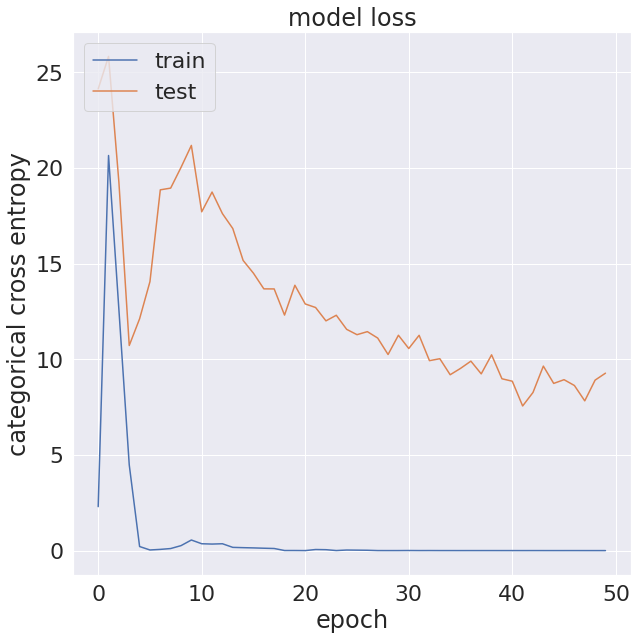

In [ ]:
####################
# display loss history
####################

import seaborn as sb

history = training_history

plt.figure(figsize=(10,10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('categorical cross entropy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# # Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# # Create a new model instance
# model = create_model()

# # Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

# # Evaluate the model
# loss, acc = model.evaluate(test_images, test_labels, verbose=2)
# print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

#Display confusion Matrix

           values
arabic        0.0
bengali       0.0
bulgarian     0.0
cantonese     3.0
english       2.0
amharic       0.0
dutch         2.0
farsi         3.0
french        1.0
Accuracy : 0.3055555555555556
Chance Accuracy would be 0.1111111111111111
Finished


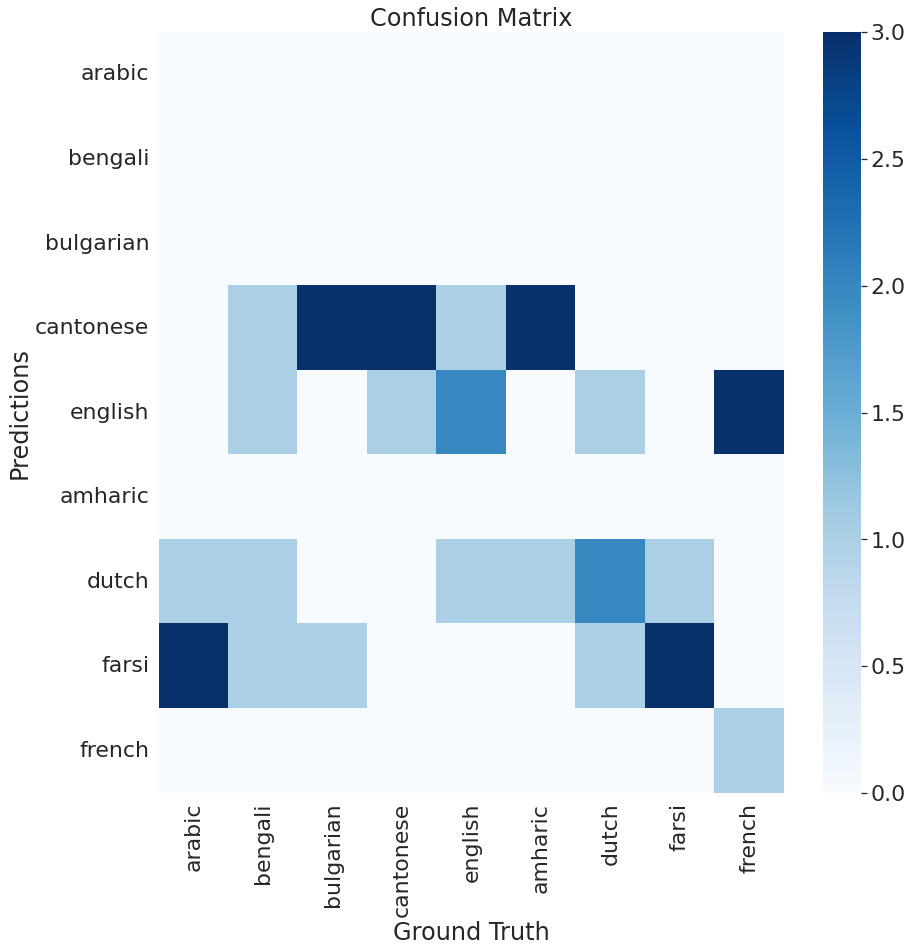

In [ ]:
####################
# display confusion matrix
####################

from sklearn.metrics import confusion_matrix

preds_df = pd.DataFrame({'GroundTruth': ground_truth_categorical, 'Predictions':predictions_categorical})
# print(preds_df)
num_categories = len(training_languages_dict)
confusion_matrix = np.zeros([num_categories,num_categories])
for index in range(len(predictions_categorical)):
  confusion_matrix[predictions_categorical[index], ground_truth_categorical[index]] += 1

plt.figure(figsize=(14,14))
tick_labels = list(training_languages_dict.keys())
ax = sb.heatmap(confusion_matrix, 
                xticklabels=tick_labels, 
                yticklabels=tick_labels, 
                annot=False, 
                fmt='', 
                cmap='Blues')

ax.set(title="Confusion Matrix",
      ylabel="Predictions",
      xlabel="Ground Truth",)
 
sb.set(font_scale=2) # set fontsize 2

cm_diag=[confusion_matrix[ind,ind] for ind in range(confusion_matrix.shape[0])]
cm_diag_df = pd.DataFrame({'values':cm_diag},index=tick_labels)

# Convert the whole dataframe as a string and display
# The scope of these changes made to
# pandas settings are local to with statement.
print("Diagonal elemets of the confusion matrix:")
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(cm_diag_df)

print(f"Accuracy : {sum(cm_diag)/sum(sum(confusion_matrix))}")
print(f"Chance Accuracy would be {1./len(cm_diag)}")
print("Finished")